## Lab 4

Saransh Kacharia
<br>
Nobember 1st, 2020

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import xarray as xr
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

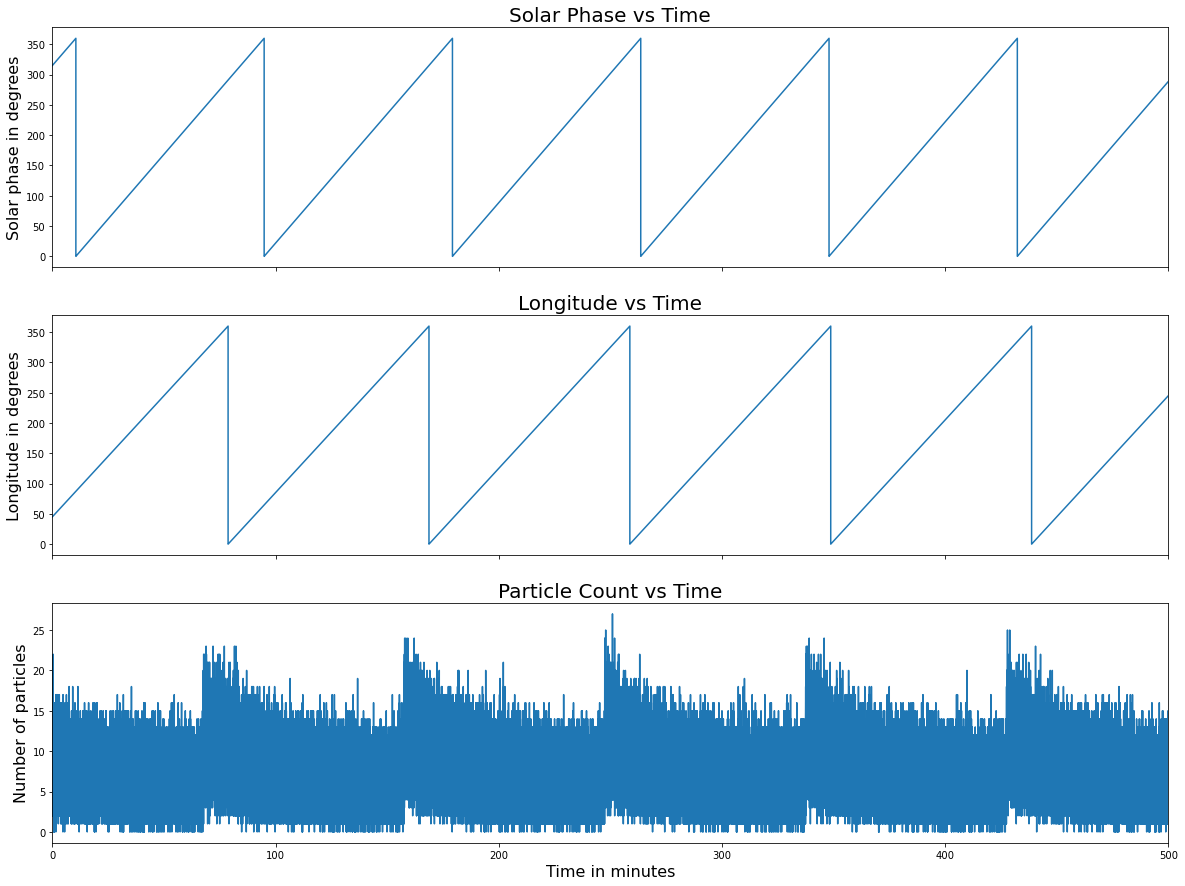

In [3]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

n = 300000
ax[0].plot((data[0,:n]-data[0,0])/60, data[1,:n])
ax[0].set_title('Solar Phase vs Time', fontsize=20)
ax[0].set_ylabel('Solar phase in degrees', fontsize=16)
ax[1].plot((data[0,:n]-data[0,0])/60, data[2,:n])
ax[1].set_title('Longitude vs Time', fontsize=20)
ax[1].set_ylabel('Longitude in degrees', fontsize=16)
ax[2].plot((data[0,:n]-data[0,0])/60, data[3,:n])
ax[2].set_title('Particle Count vs Time', fontsize=20)
ax[2].set_ylabel('Number of particles', fontsize=16)
ax[2].set_xlabel('Time in minutes', fontsize=16)

for axis in ax:
    axis.set_xlim(0, 500)

plt.show()

I plotted 300,000 rows of the data which shows data through 500 minutes. As we can see in the Longitude vs Time plot, the orbit is approximately 90 minutes. The Solar Phase vs Time plot has a period that is smaller than the Logitude vs Time plot because of the earths rotation.

We also see a similar periodic shape in the background. This suggests that there is a background periodic signal which is contaminating the data. We  expect the background cosmic radiation to be a steady signal with no discernable patterns.

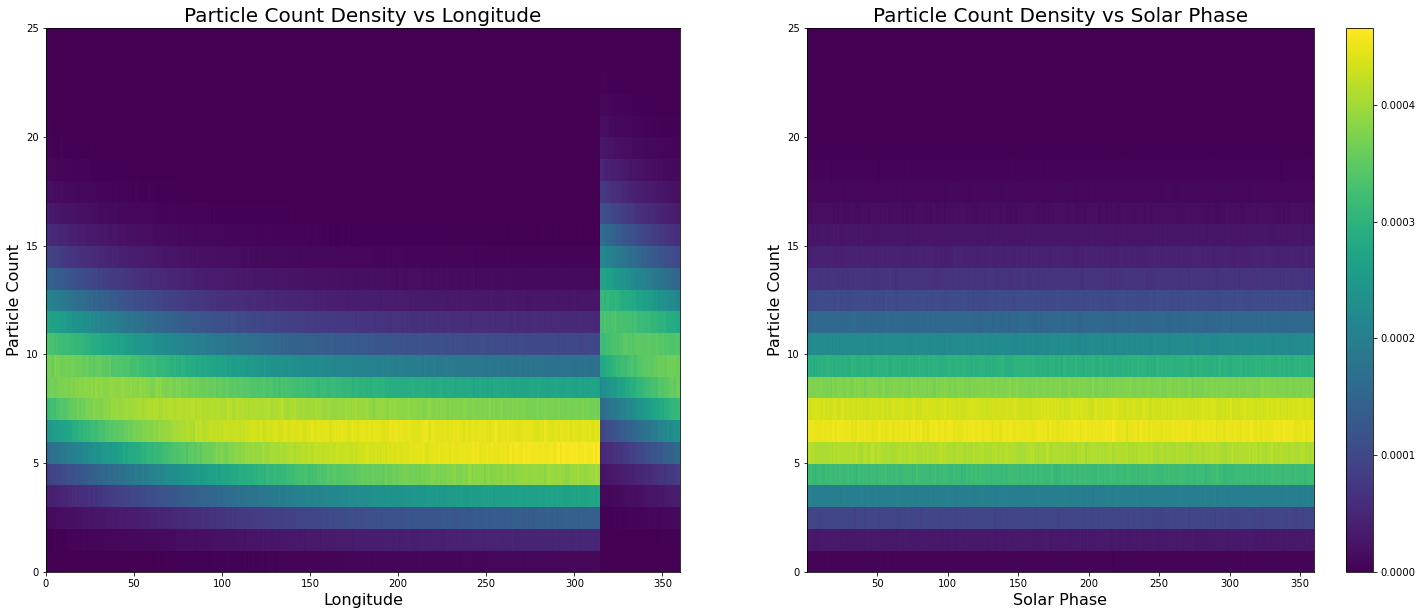

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

h1 = ax[0].hist2d(data[2,:], data[3,:], bins=(360,30), density=True)
ax[0].set_title("Particle Count Density vs Longitude", fontsize = 20)
ax[0].set_ylabel("Particle Count", fontsize = 16)
ax[0].set_xlabel("Longitude", fontsize = 16)
ax[0].set_ylim(0, 25)

h2 = ax[1].hist2d(data[1,:], data[3,:], bins=(360,30), density=True)
ax[1].set_title("Particle Count Density vs Solar Phase", fontsize = 20)
ax[1].set_ylabel("Particle Count", fontsize = 16)
ax[1].set_xlabel("Solar Phase", fontsize = 16)
ax[1].set_ylim(0, 25)
fig.colorbar(h1[3])

plt.show()

From the plots above we can conclude that the solar phase doesn't affect the background but the logitude does. As the longitude goes from 0 to 360 degrees we see the particle count decrease from -45 to 105 degrees before flattening out until 315 degrees, after which is jumps back up and cycles again.

Cosmic rays should be constant and independent of longitude. This confirms our theory that there is a periodic signal contamination in the background that depends on longitude.

We know that the number of cosmic rays is a finite number so we can find a Poisson distribution for each degree of Longitude. To do that we can find a mean for each longitude and then calculate a Poisson distribution with that mean.

In [5]:
means = [np.mean(data[3][i::54000]) for i in range(54000)]
longe = [data[2][i] for i in range(54000)]

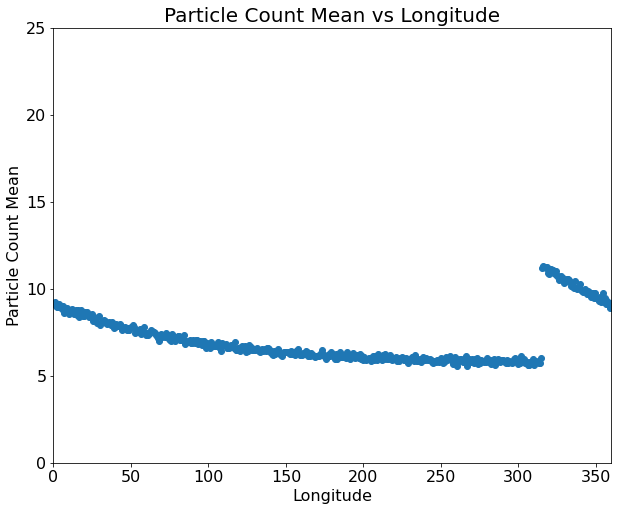

In [6]:
plt.figure(figsize=(10, 8))
plt.tick_params(labelsize = 16)
plt.title("Particle Count Mean vs Longitude", fontsize = 20)
plt.ylabel("Particle Count Mean", fontsize = 16)
plt.xlabel("Longitude", fontsize = 16)
plt.ylim(0, 25)
plt.xlim(0, 360)
plt.scatter(longe[::100], means[::100])
plt.show()

This is a plot of the mean of the particle count at each Longitude. As expected, it follows the brightest region of the 2D Histogram.

The PDF with time dependence can be modeled with a function that calculates the Longitude from the time and then determines the PMF from the Poisson distribution at that Longitude.

In [7]:
def pdf(x, time):
    longeVal = data[2][time*10]
    idx = (np.abs(longe - longeVal)).argmin()
    return stats.poisson.pmf(x, means[idx])

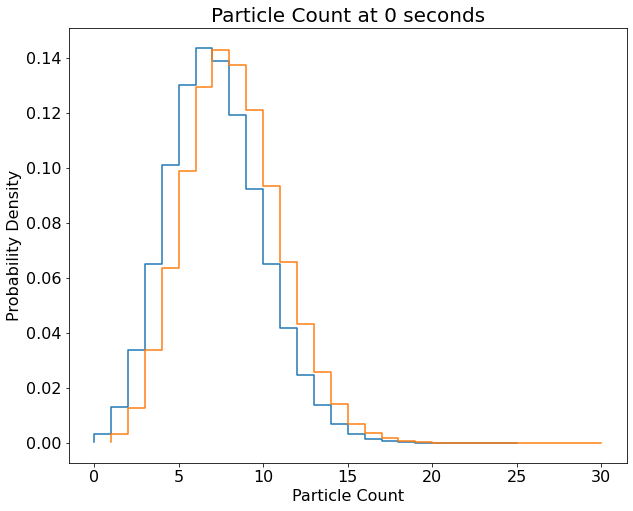

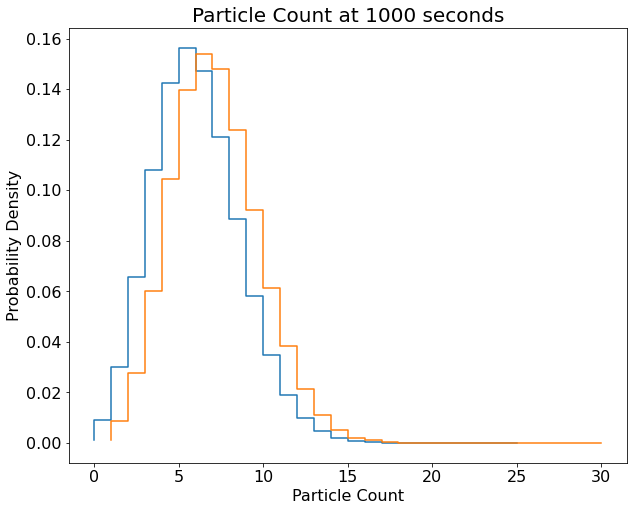

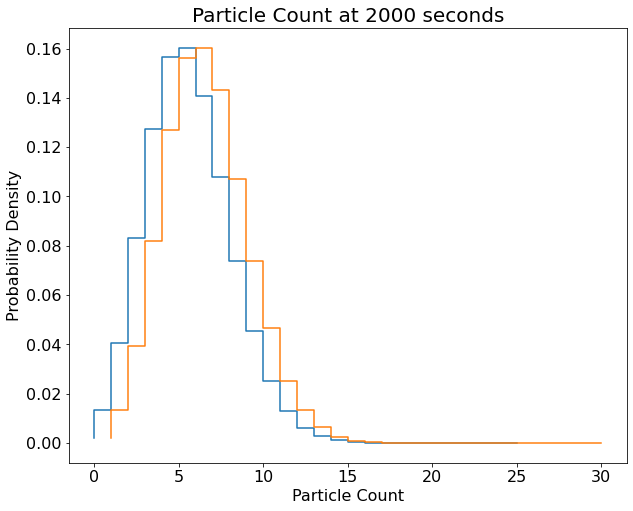

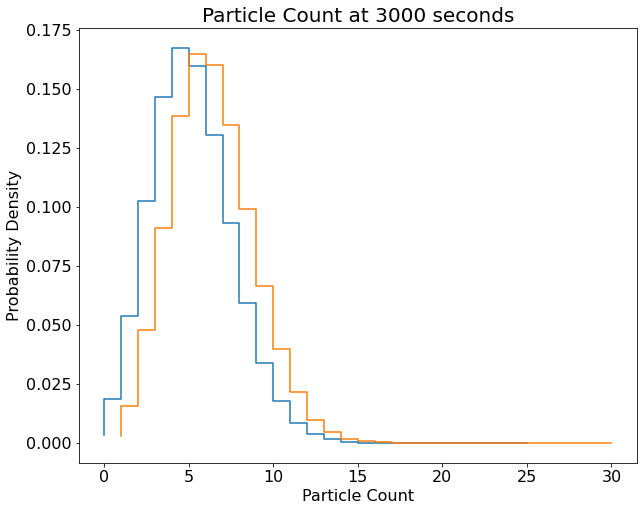

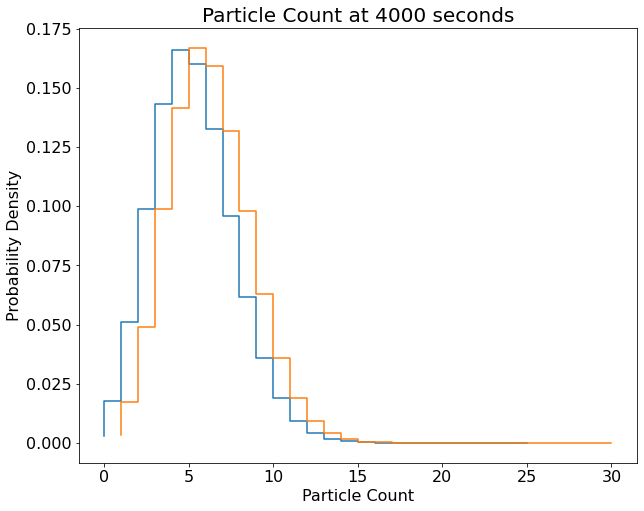

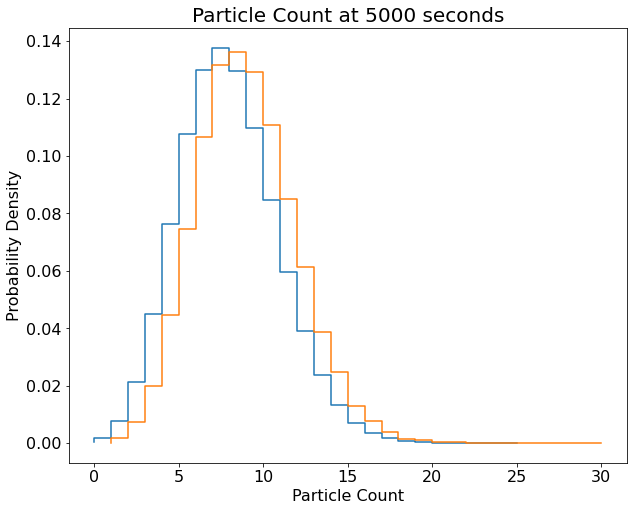

In [8]:
def compareModel(time):
    x = np.arange(0,26)
    plt.figure(figsize=(10, 8))
    plt.tick_params(labelsize = 16)
    plt.title(f"Particle Count at {time} seconds", fontsize = 20)
    plt.ylabel("Probability Density", fontsize = 16)
    plt.xlabel("Particle Count", fontsize = 16)
    plt.step(x, pdf(x, time))

    longeVal = data[2][time*10]
    
    normFactor = 1/sum(h1[0][int(longeVal)])
    x1 = h1[2][1:]
    plt.step(x1, h1[0][int(longeVal),:]*normFactor)

    plt.show()

compareModel(0)
compareModel(1000)
compareModel(2000)
compareModel(3000)
compareModel(4000)
compareModel(5000)

Comparing our model to the data, we can see that our model performs well. The real data distribution is shifted slightly to the right because our model calculate the distribution more finely. When comparing it with real data we determine the Logitude at that given time then we average our data over 1 degree. This results in a slight shift to the right because we are including a greater range of times.

We can now find the 5-sigma threshold for different time/longitude values.

In [9]:
def sigma5(time):
    longeVal = data[2][time*10]
    idx = (np.abs(longe - longeVal)).argmin()
    sigma = 1 - stats.norm.cdf(5)
    requiredParticles = stats.poisson.ppf(1-sigma, mu = means[idx])
    print(f'Measurement needed for 5-sigma confidence at {time:4d} seconds: {requiredParticles}')

sigma5(0)
sigma5(4000)
sigma5(4060)

Measurement needed for 5-sigma confidence at    0 seconds: 25.0
Measurement needed for 5-sigma confidence at 4000 seconds: 21.0
Measurement needed for 5-sigma confidence at 4060 seconds: 32.0


As we can see, the sigma value changes for different times/longitudes. It ranges from 21 to 32 depending on the time/longitude.

This dependance of the particle count on longitude comes from the South Atlantic Anomaly. In this region we measure a greater number of cosmic rays.

## Problem 2

In this problem we are going to look at a stack of telescope images. From these images we will determine the faintest stars.

In [ ]:
hf = h5py.File('images.h5', 'r')
stack = xr.DataArray(hf.get('imagestack')[:,:,:], coords=[np.arange(200), np.arange(200),np.arange(10)], dims=['x', 'y', 'image']).transpose('image','x','y')
stack.plot(center=False, col='image', col_wrap=2, size=5)
hf.close()
plt.show()

<img src="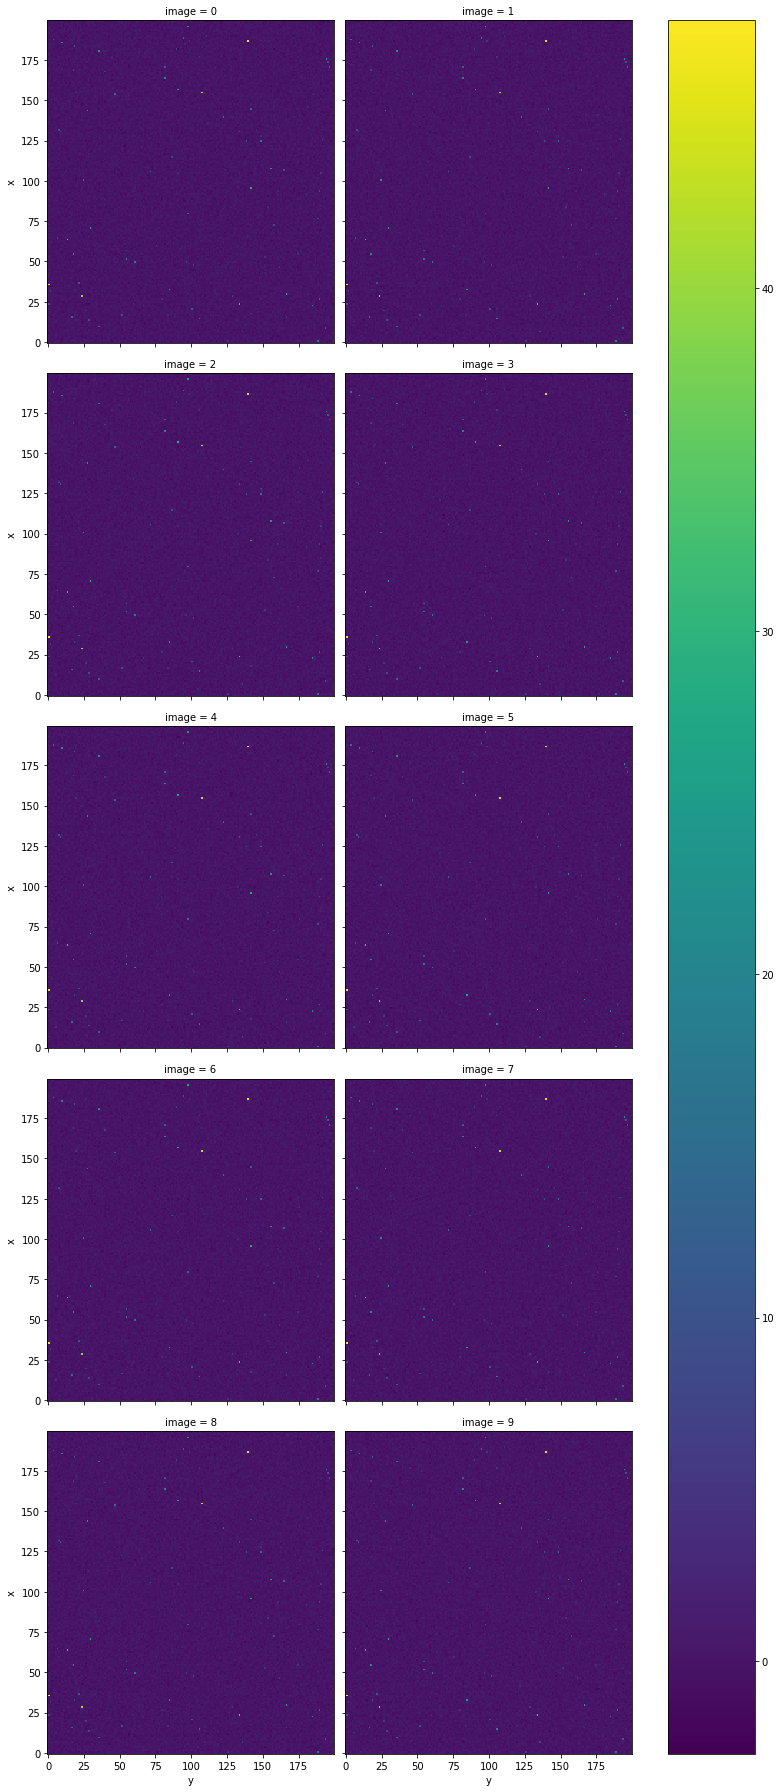%0A" />

From these images, it is difficult to locate the faintest stars. Something we can do is to calculate a PDF of the pixel brightness of all the images, and because a stars brightness is independent of time, that star should be there for all of the images. Due to this we can sum the brightness for each pixel between the images then find the PDF. There is some contamination but when summing all the images the contamination will be washed out.

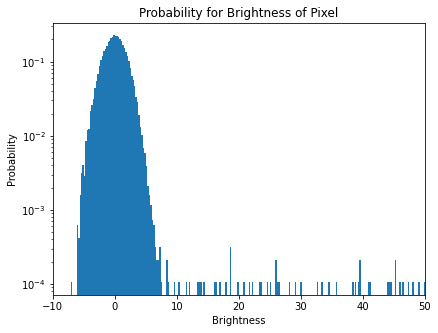

In [11]:
stack_sum = sum(stack)
stack_sum.plot.hist(bins=2000, density=True, size=5)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,50])
plt.ylabel("Probability")
plt.xlabel("Brightness")
plt.yscale('log')
plt.show()

We can see that the background is a normal distribution and the stars which are brighter are outside the background distribution. We can determine the mean and standard deviation of the background distribution to count the number of stars that are any sigma threshold brighter than the background.

We can remove any data points that are greater that 8 brightness to calculate the mean and standard deviation of the background.

In [12]:
stack_sum_trimmed = stack_sum.where(stack_sum < 8)
mean = stack_sum_trimmed.mean().values
std = stack_sum_trimmed.std().values
print(f"Mean: {mean:.3f}")
print(f"Standard Deviation: {std:.3f}")

Mean: -0.002
Standard Deviation: 1.776


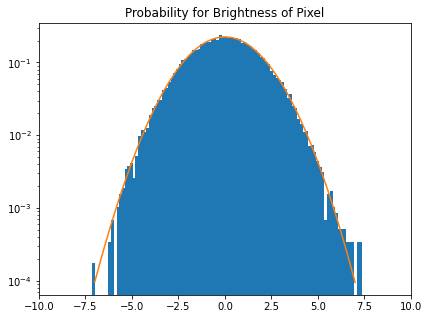

In [14]:
stack_sum_trimmed.plot.hist(bins=100, density=True, size=5)
x = np.linspace(-7,7,1000)
pdf = stats.norm.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,10])
plt.yscale('log')
plt.show()

We find that the background brightness has a mean of -0.002 and a standard deviation of 1.776. We can see from the plot that a normal distribution with these parameters fits the background data well. Now we can find faint stars by counting the number of stars that are brighter with sigma values greater than a certain threshold.

In [15]:
def stars(sigma):
    prob = 1 - stats.norm.cdf(sigma)
    requiredBrightness = stats.norm.ppf(1 - prob, loc=mean, scale=std)
    print(f"Brightness of {requiredBrightness:.2f} or more is {sigma} sigma")
    n = stack_sum.where(stack_sum > requiredBrightness).count().values
    print(f"There are {n} pixels bright enough to be stars with {sigma} sigma certainty.")

In [16]:
stars(5)
print("")
stars(7)

Brightness of 8.88 or more is 5 sigma
There are 125 pixels bright enough to be stars with 5 sigma certainty.

Brightness of 12.43 or more is 7 sigma
There are 121 pixels bright enough to be stars with 7 sigma certainty.


We can conclude with 5 sigma certainty that there are 125 stars. We can conclude with 7 sigma certainty that there are 121 stars. That means there are 4 stars that are the faintest stars with brightnesses between 8.88 and 12.43 when all the images are summed.

My partner and I had a different PDF because we were looking for different things. To look for a transient, the PDF that would have been used in that case would be to average of all the images and then subtracting each image from the average. After which you could find the probability of seeing something that isn't in any of the other images.